In [1]:
import os
os.chdir('..')
from src.feature_engineering import freture_extract_All
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Show more columns
pd.set_option('display.max_columns', None) 

# Show more rows
pd.set_option('display.max_rows', 100) 

In [31]:
df = freture_extract_All()
df
df

,member_id,churn,outreach,months_in_app,diet_visits,physical_activity_visits,sleep_visits,resilience_visits,clinical_visits,total_health_visits,total_visits,diet_visits_ratio,physical_activity_visits_ratio,sleep_visits_ratio,resilience_visits_ratio,clinical_visits_ratio,total_health_visits_ratio,non_relevant_visits,health_engagement_ratio,category_diversity,app_usage,icd_code_A09,icd_code_B34.9,icd_code_E11.9,icd_code_H10.9,icd_code_I10,icd_code_J00,icd_code_K21.9,icd_code_M54.5,icd_code_R51,icd_code_Z71.3,code_count,priority_condition_count
0,1,0,0,13,0.0,0.0,0.0,0.0,2.0,2.0,3.0,0.000000,0.000000,0.000000,0.000000,0.666667,0.666667,1.0,0.666667,1.0,6.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,1.0,0.0,2.0,9.0,4.0
1,2,0,0,2,1.0,2.0,1.0,1.0,3.0,8.0,9.0,0.111111,0.222222,0.111111,0.111111,0.333333,0.888889,1.0,0.888889,5.0,10.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,9.0,7.0
2,3,0,0,8,5.0,6.0,4.0,3.0,5.0,23.0,52.0,0.096154,0.115385,0.076923,0.057692,0.096154,0.442308,29.0,0.442308,5.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,4.0,1.0
3,4,1,0,13,0.0,1.0,2.0,2.0,2.0,7.0,15.0,0.000000,0.066667,0.133333,0.133333,0.133333,0.466667,8.0,0.466667,4.0,10.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,5.0,3.0
4,5,0,1,14,1.0,2.0,2.0,0.0,1.0,6.0,11.0,0.090909,0.181818,0.181818,0.000000,0.090909,0.545455,5.0,0.545455,4.0,10.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0,8,1.0,2.0,2.0,1.0,7.0,13.0,18.0,0.055556,0.111111,0.111111,0.055556,0.388889,0.722222,5.0,0.722222,5.0,8.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,9.0,4.0
9996,9997,0,0,15,2.0,2.0,0.0,0.0,0.0,4.0,8.0,0.250000,0.250000,0.000000,0.000000,0.000000,0.500000,4.0,0.500000,2.0,11.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,3.0
9997,9998,0,0,8,0.0,1.0,1.0,0.0,1.0,3.0,8.0,0.000000,0.125000,0.125000,0.000000,0.125000,0.375000,5.0,0.375000,3.0,12.0,0.0,2.0,0.0,2.0,0.0,4.0,2.0,1.0,1.0,2.0,14.0,2.0
9998,9999,0,0,16,4.0,3.0,2.0,1.0,2.0,12.0,36.0,0.111111,0.083333,0.055556,0.027778,0.055556,0.333333,24.0,0.333333,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,6.0,3.0


In [23]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [24]:
X = df.drop(columns=['churn', 'member_id'])
y = df['churn']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3333, random_state=42, stratify=y  
)

Classification Report:
              precision    recall  f1-score   support

    no_churn       0.83      0.84      0.84      1070
       churn       0.31      0.29      0.30       258

    accuracy                           0.74      1328
   macro avg       0.57      0.57      0.57      1328
weighted avg       0.73      0.74      0.73      1328


AUC Score: 0.6219


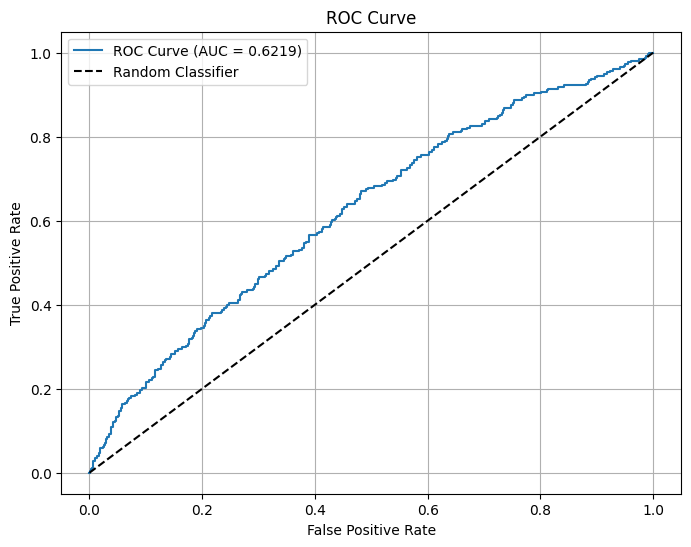

In [26]:
import xgboost as xgb
scale_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.2,
    max_depth=5,
    random_state=42,
    scale_pos_weight=scale_weight
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Classification Report
print("Classification Report:")
print(classification_report(
    y_test, 
    y_pred, 
    target_names=['no_churn', 'churn'],
    digits=2
))

# AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC Score: {auc:.4f}")

# Optional: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',  # Handles imbalance
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = model_rf.predict(X_test)
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

print("=" * 60)
print("RANDOM FOREST RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_rf, target_names=['no_churn', 'churn'], digits=2))
print(f"\nAUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

RANDOM FOREST RESULTS
              precision    recall  f1-score   support

    no_churn       0.84      0.90      0.87      1070
       churn       0.41      0.28      0.33       258

    accuracy                           0.78      1328
   macro avg       0.62      0.59      0.60      1328
weighted avg       0.76      0.78      0.77      1328


AUC Score: 0.6532


In [28]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

model_lgb.fit(X_train, y_train)

# Predictions
y_pred_lgb = model_lgb.predict(X_test)
y_pred_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]

print("=" * 60)
print("LIGHTGBM RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_lgb, target_names=['no_churn', 'churn'], digits=2))
print(f"\nAUC Score: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")

LIGHTGBM RESULTS
              precision    recall  f1-score   support

    no_churn       0.83      0.81      0.82      1070
       churn       0.29      0.32      0.31       258

    accuracy                           0.72      1328
   macro avg       0.56      0.57      0.56      1328
weighted avg       0.73      0.72      0.72      1328


AUC Score: 0.6226


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

model_lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = model_lr.predict(X_test_scaled)
y_pred_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]

print("=" * 60)
print("LOGISTIC REGRESSION RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_lr, target_names=['no_churn', 'churn'], digits=2))
print(f"\nAUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

LOGISTIC REGRESSION RESULTS
              precision    recall  f1-score   support

    no_churn       0.87      0.66      0.75      1070
       churn       0.29      0.58      0.39       258

    accuracy                           0.65      1328
   macro avg       0.58      0.62      0.57      1328
weighted avg       0.76      0.65      0.68      1328


AUC Score: 0.6640


In [30]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    auto_class_weights='Balanced',
    random_state=42,
    verbose=False
)

model_cat.fit(X_train, y_train)

# Predictions
y_pred_cat = model_cat.predict(X_test)
y_pred_proba_cat = model_cat.predict_proba(X_test)[:, 1]

print("=" * 60)
print("CATBOOST RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_cat, target_names=['no_churn', 'churn'], digits=2))
print(f"\nAUC Score: {roc_auc_score(y_test, y_pred_proba_cat):.4f}")

CATBOOST RESULTS
              precision    recall  f1-score   support

    no_churn       0.85      0.76      0.80      1070
       churn       0.31      0.44      0.36       258

    accuracy                           0.70      1328
   macro avg       0.58      0.60      0.58      1328
weighted avg       0.74      0.70      0.72      1328


AUC Score: 0.6460
